## Keras Tutorial own data

In [1]:
import os, json
import re
import zipfile
import cv2

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import parse, Element, SubElement, ElementTree

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10136919479009142945
xla_global_id: -1
]


In [3]:
print(tf.__version__)

2.8.0


In [5]:
# url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
# filename = os.path.join(os.getcwd(), "data.zip")
# keras.utils.get_file(filename, url)


# with zipfile.ZipFile("data.zip", "r") as z_fp:
#     z_fp.extractall("./")

In [4]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [5]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, ax=None, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)

    plt.axis("off")
    plt.imshow(image)
    if ax is None:
        # plt.figure(figsize=figsize)
        ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [6]:
class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [7]:
def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    """    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """ 
#     name = sample['filename']
#     print(name)
#     image = json_dict_2[name]['image']
#     bbox = json_dict_2[name]['objects']['bbox']
#     class_id = json_dict_2[name]['objects']['label']
    
#     image = tf.cast(image, dtype=tf.int32)
    
    image = sample["image"]    
    _bbox = swap_xy(sample["objects"]["bbox"])
#     _bbox = tf.cast(bbox, dtype=tf.float32)
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    length = sample["length"]
#     print(length)
    
#     _bbox = _bbox.numpy()
    
#     index = 0
#     for i in range(len(_bbox)):
#         if _bbox[i][0] != 0:
#             index = i + 1
#         else:
#             index = index

    bbox = tf.stack(_bbox[:length],axis=0)
    class_id = tf.stack(class_id[:length],axis=0)

#     class_id = [0]*len(bbox)
    
#     bbox = _bbox
    class_id = tf.cast(class_id, dtype=tf.int32)
    bbox = tf.cast(bbox, dtype=tf.float32)
#     print(bbox)
#     bbox_ = tf.stack([_bbox[0]],axis=0)
#     print(bbox_)
    
#     bbox_values = tf.get_static_value(boxes, partial=False)

#     for i in range(len(bbox_values)):
#         if bbox_values[i][0] == 0:
#             break
#     boxes = tf.slice(bbox,[0,0], [i, 4])

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)
#     image = tf.cast(image, dtype=tf.float32)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [8]:
# for sample in train_dataset.take(1):
#     image, bbox, class_id = preprocess_data(sample)
#     print(bbox)

In [9]:
class LabelEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [10]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [11]:
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [12]:
def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [13]:
class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [14]:
class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=1,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=6,
        max_detections=6,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [15]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

In [16]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 1
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [17]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer,run_eagerly=True)

In [18]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        # filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        filepath=os.path.join(model_dir, "weights"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]

In [19]:
# #  set `data_dir=None` to load the complete dataset

# (train_dataset, val_dataset), dataset_info = tfds.load(
#     "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
# )

# Own dataset

### Old

In [75]:
path = os.getcwd()
images = os.path.join(path,'dataset/images')
json_path = os.path.join(path,'dataset/annotations/default_final.json')

In [76]:
with open(json_path) as JSON:
    annotations = json.load(JSON)['items']

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict_1 = {i['image']['path']:i for i in annotations}
print(f'{len(json_dict_1)} images in dataset')

108 images in dataset


In [77]:
print(json_dict_1.keys())

dict_keys(['Tomaat_R_9.png', 'Tomaat_R_8.png', 'Tomaat_R_7.png', 'Tomaat_R_6.png', 'Tomaat_R_5.png', 'Tomaat_R_4.png', 'Tomaat_R_3.png', 'Tomaat_R_2.png', 'Tomaat_R_18.png', 'Tomaat_R_17.png', 'Tomaat_R_16.png', 'Tomaat_R_15.png', 'Tomaat_R_14.png', 'Tomaat_R_13.png', 'Tomaat_R_12.png', 'Tomaat_R_11.png', 'Tomaat_R_10.png', 'Tomaat_R_1.png', 'Tomaat_L_9.png', 'Tomaat_L_8.png', 'Tomaat_L_7.png', 'Tomaat_L_6.png', 'Tomaat_L_5.png', 'Tomaat_L_4.png', 'Tomaat_L_3.png', 'Tomaat_L_2.png', 'Tomaat_L_18.png', 'Tomaat_L_17.png', 'Tomaat_L_16.png', 'Tomaat_L_15.png', 'Tomaat_L_14.png', 'Tomaat_L_13.png', 'Tomaat_L_12.png', 'Tomaat_L_11.png', 'Tomaat_L_10.png', 'Tomaat_L_1.png', 'Top_far_L_9.png', 'Top_far_L_8.png', 'Top_far_L_7.png', 'Top_far_L_6.png', 'Top_far_L_5.png', 'Top_far_L_4.png', 'Top_far_L_3.png', 'Top_far_L_20.png', 'Top_far_L_2.png', 'Top_far_L_19.png', 'Top_far_L_18.png', 'Top_far_L_17.png', 'Top_far_L_16.png', 'Top_far_L_15.png', 'Top_far_L_14.png', 'Top_far_L_13.png', 'Top_far_L_

In [95]:
keys = ['Tomaat_L_1.png','Tomaat_L_2.png','Tomaat_L_3.png','Tomaat_L_4.png','Tomaat_L_5.png','Tomaat_L_6.png',
        'Tomaat_L_7.png','Tomaat_L_8.png','Tomaat_L_9.png','Tomaat_L_10.png','Tomaat_L_11.png','Tomaat_L_12.png',
        'Tomaat_L_13.png','Tomaat_L_14.png','Tomaat_L_15.png','Tomaat_L_16.png','Tomaat_L_17.png','Tomaat_L_18.png',
       'Tomat_far_L_1.png','Tomat_far_L_4.png','Tomat_far_L_7.png','Tomat_far_L_10.png',
       'Tomat_L_2.png','Tomat_L_5.png','Tomat_L_8.png','Tomat_L_11.png',
       'Tomat_R_3.png','Tomat_R_5.png','Tomat_R_6.png','Tomat_R_9.png',
       'Top_L_1.png','Top_L_2.png','Top_L_3.png','Top_L_4.png','Top_L_5.png','Top_L_6.png',
       'Top_L_7.png','Top_L_8.png','Top_L_9.png','Top_L_10.png','Top_L_11.png','Top_L_12.png',
       'Top_L_13.png','Top_L_14.png','Top_L_15.png','Top_L_16.png','Top_L_17.png','Top_L_18.png','Top_L_19.png','Top_L_20.png',]

In [ ]:
# make new dictionary with scaled images and bboxes
len_data = len(keys)
data_name = list(keys)
json_dict_2 = {}
desired_size = 510
larger_window = 10
# Crop bounding box
filename = []
labels_total = []
bbox_total = []
images_total = []
lengths_total = []
for i in range(0,len_data):
    data = []
    data = json_dict_1[data_name[i]]
    img_data = plt.imread(os.path.join(images, data['image']['path']))
    
    name = data_name[i]
    json_dict_2[name] = {}
    json_dict_2[name]['objects'] = {}
    json_dict_2[name]['objects']['bbox'] = {}
    json_dict_2[name]['objects']['label'] = {}
    bboxes = []
    classes = []
    
    for i, dataaa in enumerate(data['annotations']):
        # Find bboxes in image    
        if len(dataaa) == 7:
            current_bbox = dataaa['bbox']
            bboxes.append(current_bbox)
            classes.append(0)

    # resize image and bboxes to desired size
    img_data, bboxes = resize_img_and_bbox(img_data,bboxes,desired_size)
    
    bboxes_new = []
    for box in bboxes:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        new_box = [x1,y1,x2,y2]
        
        # normalize bbox
        new_box = [x/desired_size for x in new_box]
        bboxes_new.append(new_box)
        
    json_dict_2[name]['objects']['bbox'] = bboxes_new
    json_dict_2[name]['objects']['label'] = classes
    
    length = len(bboxes_new)
    for i in range(6 - length):
        bboxes_new.append([0,0,0,0])
        classes.append(0)
        
    img_data = (img_data*255).astype(int)
#     img_data = tf.convert_to_tensor(img_data, dtype=tf.int64)
    
#     bboxes_new = tf.convert_to_tensor(bboxes_new, dtype=tf.float32)
#     classes = tf.convert_to_tensor(classes, dtype=tf.float32)
    
    json_dict_2[name]['image'] = img_data
    
#     filename.append(tf.convert_to_tensor(name, dtype=tf.string))
#     labels_total.append(tf.convert_to_tensor(classes, dtype=tf.int32))
#     bbox_total.append(tf.convert_to_tensor(bboxes_new, dtype=tf.float32))
#     images_total.append(tf.convert_to_tensor(img_data, dtype=tf.int32))

    filename.append(name)
    labels_total.append(classes)
    bbox_total.append(bboxes_new)
    images_total.append(img_data)
    lengths_total.append(length)

In [ ]:
# make new dictionary with scaled images and bboxes
len_data = len(json_dict_1)
data_name = list(json_dict_1)
json_dict_2 = {}
desired_size = 510
larger_window = 10
# Crop bounding box
filename = []
labels_total = []
bbox_total = []
images_total = []
lengths_total = []
for i in range(0,len_data):
    data = []
    print(data_name[i])
    data = json_dict_1[data_name[i]]
    img_data = plt.imread(os.path.join(images, data['image']['path']))
    
    name = data_name[i]
    json_dict_2[name] = {}
    json_dict_2[name]['objects'] = {}
    json_dict_2[name]['objects']['bbox'] = {}
    json_dict_2[name]['objects']['label'] = {}
    bboxes = []
    classes = []
    
    for i, dataaa in enumerate(data['annotations']):
        # Find bboxes in image    
        if len(dataaa) == 7:
            current_bbox = dataaa['bbox']
            bboxes.append(current_bbox)
            classes.append(0)
    
    # resize image and bboxes to desired size
    img_data, bboxes = resize_img_and_bbox(img_data,bboxes,desired_size)
    
    bboxes_new = []
    for box in bboxes:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        new_box = [x1,y1,x2,y2]
        
        # normalize bbox
        new_box = [x/desired_size for x in new_box]
        bboxes_new.append(new_box)
        
    json_dict_2[name]['objects']['bbox'] = bboxes_new
    json_dict_2[name]['objects']['label'] = classes
    
    length = len(bboxes_new)
    for i in range(6 - length):
        bboxes_new.append([0,0,0,0])
        classes.append(0)
        
    img_data = (img_data*255).astype(int)
#     img_data = tf.convert_to_tensor(img_data, dtype=tf.int64)
    
#     bboxes_new = tf.convert_to_tensor(bboxes_new, dtype=tf.float32)
#     classes = tf.convert_to_tensor(classes, dtype=tf.float32)
    
    json_dict_2[name]['image'] = img_data
    
#     filename.append(tf.convert_to_tensor(name, dtype=tf.string))
#     labels_total.append(tf.convert_to_tensor(classes, dtype=tf.int32))
#     bbox_total.append(tf.convert_to_tensor(bboxes_new, dtype=tf.float32))
#     images_total.append(tf.convert_to_tensor(img_data, dtype=tf.int32))

    filename.append(name)
    labels_total.append(classes)
    bbox_total.append(bboxes_new)
    images_total.append(img_data)
    lengths_total.append(length)

### New dataset

In [19]:
path = os.getcwd()
images = os.path.join(path,'dataset_new/images')
annotations = os.listdir('dataset_new/annotations')

In [20]:
print(f'{len(annotations)} images in dataset')

263 images in dataset


In [21]:
def resize_img_and_bbox(image,boxes,desired_size):
    old_size = image.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    image_1 = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    im_new = cv2.copyMakeBorder(image_1, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    boxes_new = []
    for box in boxes:
        x1, y1, w, h = box
        
        if old_size[0] > old_size[1]:
            x1 = x1*(desired_size/old_size[0]) + left
            y1 = y1*(desired_size/old_size[0]) + top
            w = w*(desired_size/old_size[0]) #+ left
            h = h*(desired_size/old_size[0]) 

        else:
            x1 = x1*(desired_size/old_size[1]) + left
            y1 = y1*(desired_size/old_size[1]) + top
            w = w*(desired_size/old_size[1]) + left
            h = h*(desired_size/old_size[1]) 
            
        
        box = [x1, y1, w, h]
        boxes_new.append(box)
    

    return im_new, boxes_new

In [22]:
json_dict_2 = {}
desired_size = 510

filename = []
labels_total = []
bbox_total = []
images_total = []
lengths_total = []

for xml_filename in annotations:

    xml_filename_path = ('dataset_new/annotations/' + xml_filename)
    tree = ET.parse(xml_filename_path)
    root = tree.getroot()
    
    name = root[1].text
    json_dict_2[name] = {}
    json_dict_2[name]['objects'] = {}
    json_dict_2[name]['objects']['bbox'] = {}
    json_dict_2[name]['objects']['label'] = {}

    bboxes = []
    classes = []
    for _object in root.iter('object'):
        
        for bbox in _object.iter('bndbox'):
            x1 = float(bbox[0].text)
            y1 = float(bbox[1].text)
            x2 = float(bbox[2].text)
            y2 = float(bbox[3].text)
            w = x2 - x1
            h = y2 - y1
            
            bbox = [x1, y1, w, h]
            bboxes.append(bbox)
            classes.append(0)

    img_data = plt.imread(os.path.join(images, name))
    
    # resize image and bboxes to desired size
    img_data, bboxes = resize_img_and_bbox(img_data,bboxes,desired_size)
    img_data = (img_data*255).astype(int)

    # normalize bboxes
    bboxes_new = []
    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2 = x1 + w
        y2 = y1 + h
        new_box = [x1,y1,x2,y2]
        
        new_box = [x/desired_size for x in new_box]
        bboxes_new.append(new_box)
        

    json_dict_2[name]['objects']['bbox'] = bboxes_new
    json_dict_2[name]['objects']['label'] = classes
    json_dict_2[name]['image'] = img_data
    
    length = len(bboxes_new)
    for i in range(6 - length):
        bboxes_new.append([0,0,0,0])
        classes.append(0)
    
    filename.append(name)
    labels_total.append(classes)
    bbox_total.append(bboxes_new)
    images_total.append(img_data)
    lengths_total.append(length)

### Split train, val and test

In [23]:
np.random.seed(42)

In [24]:
arr = np.arange(len(filename))
np.random.shuffle(arr)

In [25]:
print(arr)

[115 120 259 226  66 249 176 216   9 101  24 111  46 223 193 215  79   6
 255  67 141 147  19 254 109 136  78  68 197  15  30 172 231 170  33 132
  73 239 209  10 117  45  96  75  25 164 204  18  86 142 152 194 114 180
 175  97 177  60  16  55 126  92 229  82 185  38 143 182 232  77 119 261
 104 168 250 124 139  84 158 137 144  69   2 125 240 179 184  90 234 253
 167  29 198 178 118 113   5  56 140 162 127  65 146  85 227 159  31  12
  35  28  42 199 108 256  22 247  93 181 245  51 112 186  95 154 212  76
 208  41 201 228  26 257 148   0 213 100 237 195  98  36  61 192 150  11
 260 211  27 165   4 122  32 155 190 138  62 135 128 242 252  70 205  64
  44 173 156  40 123 153  23 200 196  81  39 222  47  94 233 161  43 145
 183   3 105  53 133 243 206 248  49 163  80  34 225   7 171 224 110  91
  83 238 244  89   8  13  59 230 131  17 166  72 241 134 217 246  63  54
 107  50 220 174 221 189  14 207 236 219 169  58 218  48  88  21  57 203
 160 258 187 191 129  37 157 235 251   1  52 149 13

In [26]:
train_size = 0.75
val_size = 0.15
test_size = 0.10

In [27]:
index = 0
test_arr =  arr[int((test_size*index)*len(arr)):int((test_size*(index+1))*len(arr))]
rest_arr = np.hstack((arr[:int((test_size*index)*len(arr))], arr[int((test_size*(index+1))*len(arr)):]))

### Create 50 train and test sets

In [199]:
train_arrays = []
test_arrays = []
for i in range(50):
    _train_arr = np.hstack((arr[:i], arr[i+1:]))
    _test_arr =  arr[i]
    
    train_arrays.append(_train_arr)
    test_arrays.append(_test_arr)

In [276]:
for i in range(len(test_arr)):
    for j in range(len(rest_arr)):
        if test_arr[i] == rest_arr[j]:
            print(f'Found duplicate: {test_arr[i]} in both arrays')

In [28]:
train_arr = rest_arr[:int(train_size*len(arr))]
val_arr = rest_arr[int(train_size*len(arr)):]

In [29]:
print(f'{len(train_arr)} images in train set')
print(f'{len(val_arr)} images in val set')
print(f'{len(test_arr)} images in test set')

197 images in train set
40 images in val set
26 images in test set


In [30]:
filenames_train = [filename[i] for i in train_arr]
images_train = [images_total[i] for i in train_arr]
labels_train = [labels_total[i] for i in train_arr]
bbox_train = [bbox_total[i] for i in train_arr]
lengths_train = [lengths_total[i] for i in train_arr]

In [31]:
filenames_val = [filename[i] for i in val_arr]
images_val = [images_total[i] for i in val_arr]
labels_val = [labels_total[i] for i in val_arr]
bbox_val = [bbox_total[i] for i in val_arr]
lengths_val = [lengths_total[i] for i in val_arr]

In [32]:
filenames_test = [filename[i] for i in test_arr]
images_test = [images_total[i] for i in test_arr]
labels_test = [labels_total[i] for i in test_arr]
bbox_test = [bbox_total[i] for i in test_arr]
lengths_test = [lengths_total[i] for i in test_arr]

In [33]:
print(filenames_test)

['blue_201.png', 'blue_206.png', 'Top_L_6.png', 'Tomaat_L_5.png', 'blue_158.png', 'Top_L_15.png', 'blue_66.png', 'Tomaat_L_12.png', 'blue_106.png', 'blue_19.png', 'blue_12.png', 'blue_199.png', 'blue_14.png', 'Tomaat_L_2.png', 'blue_81.png', 'Tomaat_L_11.png', 'blue_17.png', 'blue_103.png', 'Top_L_20.png', 'blue_159.png', 'blue_34.png', 'blue_4.png', 'blue_115.png', 'Top_L_2.png', 'blue_197.png', 'blue_3.png']


In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_train, "image":images_train, 
                                                    "objects": {"label":labels_train, "bbox":bbox_train}, 
                                                    "length":lengths_train})

In [35]:
val_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_val, "image":images_val, 
                                                  "objects": {"label":labels_val, "bbox":bbox_val},
                                                  "length":lengths_val})

In [36]:
test_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_test, "image":images_test, 
                                                  "objects": {"label":labels_test, "bbox":bbox_test},
                                                  "length":lengths_test})

In [37]:
print(train_dataset)

<TensorSliceDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(510, 510, 3), dtype=tf.int32, name=None), 'objects': {'label': TensorSpec(shape=(6,), dtype=tf.int32, name=None), 'bbox': TensorSpec(shape=(6, 4), dtype=tf.float32, name=None)}, 'length': TensorSpec(shape=(), dtype=tf.int32, name=None)}>


## Visualize data

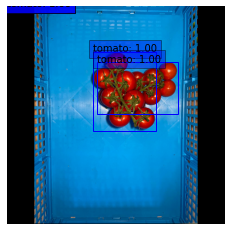

Ground truth


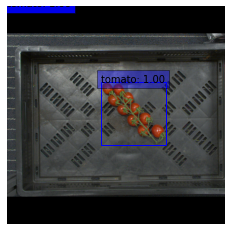

Ground truth


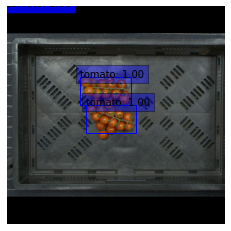

Ground truth


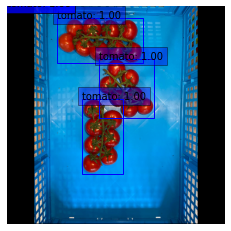

Ground truth


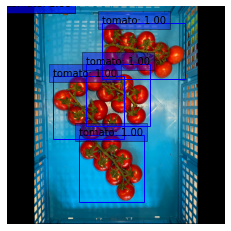

Ground truth


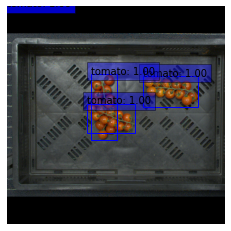

Ground truth


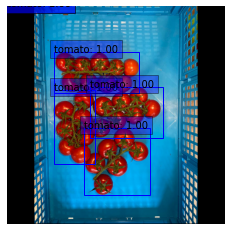

Ground truth


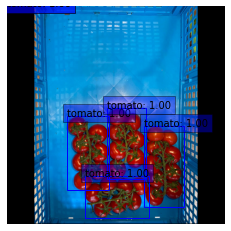

Ground truth


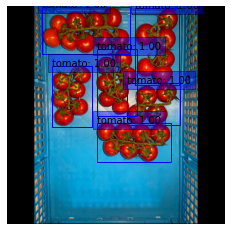

Ground truth


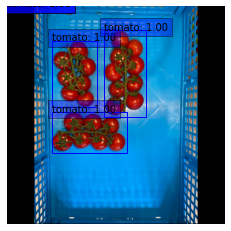

Ground truth


In [38]:
for j, sample in enumerate(val_dataset.take(10)):
    image = tf.cast(sample["image"], dtype=tf.float32)
    
    # Ground truth
    _bboxes = sample["objects"]["bbox"].numpy()
    bboxes = []
    for i in range(len(_bboxes)):
        box = [x*desired_size for x in _bboxes[i]]
        bboxes.append(box)
        
    classes = ['tomato']*len(bboxes)
    scores = [1]*len(bboxes)
    
    # Ground truth visualisation
    visualize_detections(
    image,
    bboxes,
    classes,
    scores,
    )
    plt.show()
    
    print('Ground truth')

In [243]:
# for sample in train_dataset.take(1):
#     print(sample)

In [4]:
tf.executing_eagerly() 

True

In [246]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [247]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
# # Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

# print(f'{dataset_info.splits["train"].num_examples} examples in train set')
# print(f'{dataset_info.splits["validation"].num_examples} examples in validation set')
# print(train_steps_per_epoch)
# print(epochs)

## Leave one out for for all images

In [202]:
epochs = 200

In [204]:
for i in range(len(train_arrays)):
    train_arr = train_arrays[i]
    
    filenames_train = [filename[i] for i in train_arr]
    images_train = [images_total[i] for i in train_arr]
    labels_train = [labels_total[i] for i in train_arr]
    bbox_train = [bbox_total[i] for i in train_arr]
    lengths_train = [lengths_total[i] for i in train_arr]
    
    train_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_train, "image":images_train, 
                                                    "objects": {"label":labels_train, "bbox":bbox_train}, 
                                                    "length":lengths_train})
    
    autotune = tf.data.AUTOTUNE
    train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
    train_dataset = train_dataset.shuffle(8 * batch_size)
    train_dataset = train_dataset.padded_batch(
        batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
    )
    train_dataset = train_dataset.map(
        label_encoder.encode_batch, num_parallel_calls=autotune
    )
    train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
    train_dataset = train_dataset.prefetch(autotune)
    
    
    model_dir = f"leave_one_out/_test_img_{i}/"
    
    label_encoder = LabelEncoder()

    num_classes = 1
    batch_size = 2

    learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
    learning_rate_boundaries = [125, 250, 500, 240000, 360000]
    learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=learning_rate_boundaries, values=learning_rates
    )

    resnet50_backbone = get_backbone()
    loss_fn = RetinaNetLoss(num_classes)
    model = RetinaNet(num_classes, resnet50_backbone)

    optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
    model.compile(loss=loss_fn, optimizer=optimizer,run_eagerly=True)

    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, "weights"),
            monitor="loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        )
    ]

    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=1,
    )
    history
    

Epoch 1/200
     24/Unknown - 16s 635ms/step - loss: 3.8936
Epoch 00001: loss improved from inf to 3.89363, saving model to leave_one_out/_test_img_0\weights
24/24 [==============================] - 17s 697ms/step - loss: 3.8936
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 3.9099
Epoch 00002: loss did not improve from 3.89363
24/24 [==============================] - 16s 648ms/step - loss: 3.9099
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 3.9161
Epoch 00003: loss did not improve from 3.89363
24/24 [==============================] - 17s 674ms/step - loss: 3.9161
Epoch 4/200
24/24 [==============================] - ETA: 0s - loss: 3.9039
Epoch 00004: loss did not improve from 3.89363
24/24 [==============================] - 16s 638ms/step - loss: 3.9039
Epoch 5/200
24/24 [==============================] - ETA: 0s - loss: 3.8743
Epoch 00005: loss improved from 3.89363 to 3.87428, saving model to leave_one_out/_test_img_0\weights
24/24 [====

## Evaluate leave one out

In [ ]:
for i in range(len(train_arrays)):
    # Train set
    train_arr = train_arrays[i]
    
    filenames_train = [filename[i] for i in train_arr]
    images_train = [images_total[i] for i in train_arr]
    labels_train = [labels_total[i] for i in train_arr]
    bbox_train = [bbox_total[i] for i in train_arr]
    lengths_train = [lengths_total[i] for i in train_arr]
    
    train_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_train[:1], "image":images_train[:1], 
                                                    "objects": {"label":labels_train[:1], "bbox":bbox_train[:1]}, 
                                                    "length":lengths_train[:1]})
    
    # Test set
    test_arr = test_arrays[i]
    
    filenames_test = [filename[i] for i in test_arr]
    images_test = [images_total[i] for i in test_arr]
    labels_test = [labels_total[i] for i in test_arr]
    bbox_test = [bbox_total[i] for i in test_arr]
    lengths_test = [lengths_total[i] for i in test_arr]
    
    test_dataset = tf.data.Dataset.from_tensor_slices({"filename":filenames_test, "image":images_test, 
                                                    "objects": {"label":labels_test, "bbox":bbox_test}, 
                                                    "length":lengths_test})
    
    model_dir = f"leave_one_out/_test_img_{i}/"
    
    latest_checkpoint = tf.train.latest_checkpoint(model_dir)
    model.load_weights(latest_checkpoint)
    
    image = tf.keras.Input(shape=[None, None, 3], name="image")
    predictions = model(image, training=False)
    detections = DecodePredictions(confidence_threshold=0.19)(image, predictions)
    inference_model = tf.keras.Model(inputs=image, outputs=detections)

    for j, sample in enumerate(train_dataset.take(1)):
        print(f'Train image {i}')
        image = tf.cast(sample["image"], dtype=tf.float32)

        # Ground truth
        _bboxes = sample["objects"]["bbox"].numpy()
        bboxes = []
        for i in range(len(_bboxes)):
            box = [x*desired_size for x in _bboxes[i]]
            bboxes.append(box)

        classes = ['tomato']*len(bboxes)
        scores = [1]*len(bboxes)

        # Prediction
        input_image, ratio = prepare_image(image)
        detections = inference_model.predict(input_image)
        num_detections = detections.valid_detections[0]
        class_names = [
            int(x) for x in detections.nmsed_classes[0][:num_detections]
        ]
        bboxes_pred = swap_xy(detections.nmsed_boxes[0][:num_detections] / ratio)

        print(f'Prediction: {num_detections} detections')

        # Compute IoU
        bboxes = tf.cast(bboxes, dtype=tf.float32)
        length = sample["length"].numpy()
        bboxes = bboxes[:length]
        IoU = compute_iou(bboxes,bboxes_pred).numpy()

        accuracy, scores = calculate_pred_accuracy(IoU,length,num_detections)
        print(f'Accuracy of: {accuracy}')

        # Prediction visualisation
        visualize_detections(
            image,
            bboxes_pred,
            class_names,
            detections.nmsed_scores[0][:num_detections],
        )
    
    for j, sample in enumerate(test_dataset.take(1)):
        print(f'Test image {i}')
        image = tf.cast(sample["image"], dtype=tf.float32)

        # Ground truth
        _bboxes = sample["objects"]["bbox"].numpy()
        bboxes = []
        for i in range(len(_bboxes)):
            box = [x*desired_size for x in _bboxes[i]]
            bboxes.append(box)

        classes = ['tomato']*len(bboxes)
        scores = [1]*len(bboxes)

        # Prediction
        input_image, ratio = prepare_image(image)
        detections = inference_model.predict(input_image)
        num_detections = detections.valid_detections[0]
        class_names = [
            int(x) for x in detections.nmsed_classes[0][:num_detections]
        ]
        bboxes_pred = swap_xy(detections.nmsed_boxes[0][:num_detections] / ratio)

        print(f'Prediction: {num_detections} detections')

        # Compute IoU
        bboxes = tf.cast(bboxes, dtype=tf.float32)
        length = sample["length"].numpy()
        bboxes = bboxes[:length]
        IoU = compute_iou(bboxes,bboxes_pred).numpy()

        accuracy, scores = calculate_pred_accuracy(IoU,length,num_detections)
        print(f'Accuracy of: {accuracy}')

        # Prediction visualisation
        visualize_detections(
            image,
            bboxes_pred,
            class_names,
            detections.nmsed_scores[0][:num_detections],
        )

## Regular training

In [254]:
epochs = 60

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)
history

Epoch 1/60
     98/Unknown - 66s 665ms/step - loss: 3.9475
Epoch 00001: loss improved from inf to 3.94752, saving model to retinanet_263_imgs_60epochs\weights
98/98 [==============================] - 74s 751ms/step - loss: 3.9475 - val_loss: 3.9253
Epoch 2/60
98/98 [==============================] - ETA: 0s - loss: 3.9162
Epoch 00002: loss improved from 3.94752 to 3.91623, saving model to retinanet_263_imgs_60epochs\weights
98/98 [==============================] - 76s 766ms/step - loss: 3.9162 - val_loss: 3.8763
Epoch 3/60
98/98 [==============================] - ETA: 0s - loss: 3.5759
Epoch 00003: loss improved from 3.91623 to 3.57589, saving model to retinanet_263_imgs_60epochs\weights
98/98 [==============================] - 75s 756ms/step - loss: 3.5759 - val_loss: 3.2785
Epoch 4/60
98/98 [==============================] - ETA: 0s - loss: 3.0595
Epoch 00004: loss improved from 3.57589 to 3.05948, saving model to retinanet_263_imgs_60epochs\weights
98/98 [===========================

KeyboardInterrupt: 

In [68]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

In [39]:
# Changed to `model_dir`, not using the downloaded weights

latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [78]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.19)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [120]:
# When predicting with own data
train_dataset = tf.data.Dataset.from_tensor_slices({"filename":filename[:85], "image":images_total[:85], 
                                                    "objects": {"label":labels_total[:85], "bbox":bbox_total[:85]}, 
                                                    "length":lengths_total[:85]})

In [79]:
def calculate_pred_accuracy(IoU,length,num_detections):
                    
    scores = []
    
    for i in range(len(IoU[0])):
        max_value = 0
        for j in range(len(IoU)):
            for k in range(len(IoU[j])):
                if IoU[j,k] > max_value:
                    max_value = IoU[j,k]
                    j_max = j
                    k_max = k
        
        scores.append(max_value)
        IoU[j_max] = 0
        IoU[:,k_max] = 0
            
    # Add a score of 0 for when a truss is not detected at all
    for i in range(length - num_detections):
        scores.append(0)
        
    accuracy = np.mean(scores)
    
    return accuracy, scores


Prediction: 6 detections
Accuracy of: 0.3737303862969081


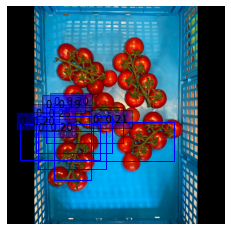

Prediction: 0 detections
Accuracy of: 0.0


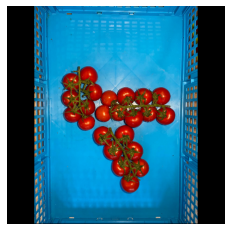

In [84]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


# val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
# int2str = dataset_info.features["objects"]["label"].int2str

# fig = plt.figure(figsize=(20,20))
# plt.suptitle('Train images',fontsize=38, y=1.0)
# for sample in val_dataset.take(4):
for j, sample in enumerate(train_dataset.take(2)):
# for sample in test_dataset.take(4):
    image = tf.cast(sample["image"], dtype=tf.float32)
    
    # Ground truth
    _bboxes = sample["objects"]["bbox"].numpy()
    bboxes = []
    for i in range(len(_bboxes)):
        box = [x*desired_size for x in _bboxes[i]]
        bboxes.append(box)
        
    classes = ['tomato']*len(bboxes)
    scores = [1]*len(bboxes)
    
    # Prediction
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int(x) for x in detections.nmsed_classes[0][:num_detections]
    ]
    bboxes_pred = swap_xy(detections.nmsed_boxes[0][:num_detections] / ratio)
    
    print(f'Prediction: {num_detections} detections')
    
    # Compute IoU
    bboxes = tf.cast(bboxes, dtype=tf.float32)
    length = sample["length"].numpy()
    bboxes = bboxes[:length]
    # print(bboxes)
    # print(bboxes_pred)
    IoU = compute_iou(bboxes,bboxes_pred).numpy()
    # print(IoU)
    
    accuracy, scores = calculate_pred_accuracy(IoU,length,num_detections)
    print(f'Accuracy of: {accuracy}')
    # print(scores)
    
    # Prediction visualisation
    visualize_detections(
        image,
        bboxes_pred,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [249]:
def plot_training_history(history, model, title):
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['training', 'validation'], loc='best')
#     plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()

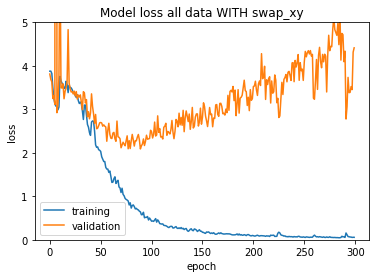

In [86]:
plot_training_history(history, model, title='Model loss all data WITH swap_xy')

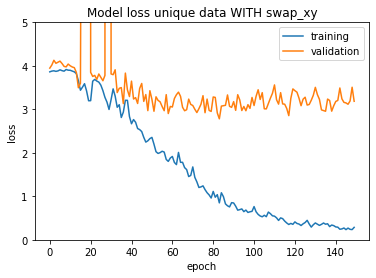

In [147]:
plot_training_history(history, model, title='Model loss unique data WITH swap_xy')

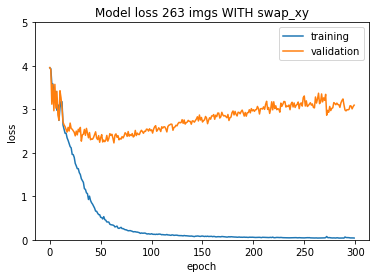

In [250]:
plot_training_history(history, model, title='Model loss 263 imgs WITH swap_xy')

### Save model

In [130]:
model.save(path + '/model')

INFO:tensorflow:Assets written to: C:\Users\jensz\Documents\Studie\Thesis\Hugo's internship\Final_Tomato_Detection/model\assets


INFO:tensorflow:Assets written to: C:\Users\jensz\Documents\Studie\Thesis\Hugo's internship\Final_Tomato_Detection/model\assets


In [147]:
model.summary()

Model: "RetinaNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeaturePyramid (FeaturePyra  multiple                 31585152  
 mid)                                                            
                                                                 
 sequential_10 (Sequential)  (None, None, None, 9)     2381065   
                                                                 
 sequential_11 (Sequential)  (None, None, None, 36)    2443300   
                                                                 
Total params: 36,409,517
Trainable params: 36,356,397
Non-trainable params: 53,120
_________________________________________________________________
